In [224]:

# Notes from https://learn.datacamp.com/courses/introduction-to-portfolio-risk-management-in-python

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro, norm, t
import statsmodels.formula.api as smf


In [6]:
# log returns: for compounding
def log_return(portfolio_time1, portfolio_time2):
    return np.log(portfolio_time2) - np.log(portfolio_time1)  # np.log() = ln()


print(np.log(2.718281))  # confirm to base of e
np.log(np.power(2.718281, 2))

0.999999695226903


1.999999390453806

In [28]:
# get stock for a company
os.chdir('/Users/apple/Desktop/quant_py_notebooks/kaggle_finance_data/Stocks')
print('stocks: ' + str(os.listdir()[:5]))

wpz = pd.read_csv('wpz.us.txt', parse_dates = ['Date'])  # tell it which columns to treat as a date
wpz = wpz.sort_values(by = 'Date')
wpz.set_index('Date', inplace = True)

print(wpz.dtypes)

stocks: ['iba.us.txt', 'wpz.us.txt', 'opnt.us.txt', 'indf.us.txt', 'flic.us.txt']
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object


In [33]:
wpz['returns'] = wpz.High.pct_change()  # calc change from previous value in column 'High'
wpz.head()

,Open,High,Low,Close,Volume,OpenInt,returns
Date,,,,,,,
2005-08-16,15.297,15.297,15.297,15.297,0,0,NaN
2005-08-18,17.716,19.033,17.707,18.142,5107636,0,0.244231
2005-08-19,18.142,18.568,18.142,18.427,474374,0,-0.024431
2005-08-22,18.536,18.776,18.447,18.719,257919,0,0.011202
2005-08-23,18.812,19.637,18.766,19.341,292214,0,0.045856


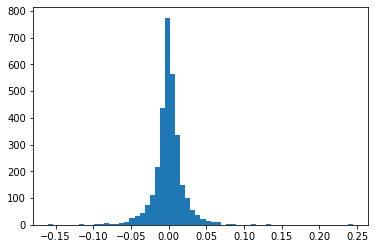

In [40]:
plt.hist(wpz['returns'].dropna(), bins = 60, density = False) # density=F makes freq appear on y axis, not probability
plt.show()

In [51]:
print('annual return of: ' + str((1 + np.mean(wpz.returns))**252 - 1))  # 252 trading days in a year
print(np.std(wpz.returns))  # sdev

print('volatility annual: ', str(np.std(wpz.returns) * np.sqrt(252)))
print('volatility monthly: ', str(np.std(wpz.returns) * np.sqrt(252 / 12)))
print('volatility scales with sqrt of days trading: linked to SD being square root of the variance')

annual return of: 0.1467947660454485
0.02252452025630455
volatility scales with sqrt of days trading:  0.35756567399531214
volatility scales with sqrt of days trading:  0.10322031906708172


In [54]:
skew(wpz.returns.dropna())  # skew above 0 suggests non-normality: >0 means positive skew (mean=higher than median)

1.1520306018605941

In [58]:
# Leptokurtic = tend to have kurtoisis above 3 (which is a expected value for kurtosis in normal distribution)

def excess_kurtosis(input_kurtosis):
    return input_kurtosis - 3 

print('kurtosis :' + str(excess_kurtosis(kurtosis(wpz.returns.dropna()) )))

# high kurtosis = 'thick tails', which outliers with high positive returns are more common

kurtosis :16.008408023061946


In [62]:
# shapiro-wilk test for normality
shapiro(wpz.returns.dropna())    # p-value below 0.05 suggests data isnt normally distributed

ShapiroResult(statistic=0.8140473365783691, pvalue=0.0)

In [82]:
# getting stocks for more companies
opnt = pd.read_csv('opnt.us.txt', parse_dates = ['Date'])  # tell it which columns to treat as a date
opnt = opnt.sort_values(by = 'Date')
opnt.set_index('Date', inplace = True)
opnt['returns'] = opnt.High.pct_change() 


flic = pd.read_csv('flic.us.txt', parse_dates = ['Date'])  # tell it which columns to treat as a date
flic = flic.sort_values(by = 'Date')
flic.set_index('Date', inplace = True)
flic['returns'] = flic.High.pct_change() 


In [72]:
print(np.repeat(1, 5))
print(opnt.High.mul(10).head())  # multiply all values in col 'High' by 10

[1 1 1 1 1]
Date
2017-08-29    279.5
2017-08-30    363.0
2017-08-31    366.0
2017-09-01    405.0
2017-09-05    400.0
Name: High, dtype: float64


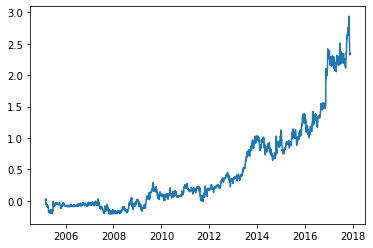

In [75]:
flic['cumulative_returns'] = (1 + flic.returns).cumprod() - 1
plt.plot(flic['cumulative_returns'])

In [102]:
# to get correlation between all stocks
stocks = wpz.merge(opnt, how = 'inner', on = 'Date').merge(flic, how = 'inner', on = 'Date')
stock_returns = stocks[['returns_x', 'returns_y', 'returns']]
print(stock_returns.corr())



           returns_x  returns_y   returns
returns_x   1.000000  -0.125084  0.163866
returns_y  -0.125084   1.000000 -0.146104
returns     0.163866  -0.146104  1.000000


In [103]:
print(stock_returns.cov())   # correlation is scaled covariance

           returns_x  returns_y   returns
returns_x   0.000100  -0.000156  0.000027
returns_y  -0.000156   0.015229 -0.000300
returns     0.000027  -0.000300  0.000272


In [104]:
print(stock_returns.cov() * 252)    # covariance scales linearly with days trading

           returns_x  returns_y   returns
returns_x   0.025252  -0.039302  0.006819
returns_y  -0.039302   3.837658 -0.075609
returns     0.006819  -0.075609  0.068566


In [105]:
### calculate portfolio standard deviation
cov_mat = stock_returns.cov()
weights = np.random.randn(3, 1)   # weight given to each stock

daily_portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))  # mult by rows and cols with weights
print('daily_portfolio_volatility: ' + str(daily_portfolio_volatility))
print('annual_portfolio_volatility: ' + str(daily_portfolio_volatility * np.sqrt(252)))

daily_portfolio_volatility: [[0.03512208]]
annual_portfolio_volatility: [[0.5575457]]


In [137]:
# may have 100,000s of portfolio combinations to select from 

# sharpe ratio = measure of return from each additional unit of risk
def sharpe_ratio(R_a, r_f, sigma):
    """
    R_a = asset return
    r_f = risk free rate of return (this is sometimes set to zero)
    sigma = asset volatility
    
    excess return = R_a - r_f
    """
    return (R_a - r_f) / sigma


# theory: there's a frontier of possible returns for a given level of risk (a curve of volatility and expected return)
# want to find portfolios on this frontier

### There are two common optimal portfolios, they come under the banner 'Markowitz portfolios':
# Max Sharpe Ratio (MSR), trading off risk and return
# Global Minimum Volatility (GMV), lowest volatility

# says GMV tends to do well over time whereas MSR can be inconsistent

In [143]:
def get_annual_volatility(x):
    x = x[~np.isnan(x)]  # drop na (tilde ~ inverts logic)
    return np.std(x) * np.sqrt(252)

def get_annual_return(x):
    x = x[~np.isnan(x)]   
    out =  [(1 + x).cumprod() - 1]  # cumulative return
    return (out[0][-1]) * 252 / len(x)   # annualised value, taking last value in cumprod vector


# get returns and volatility, putting them into Sharpe ratio calc
annual_volatility = np.apply_along_axis(get_annual_volatility, 0, stock_returns)
annual_return = np.apply_along_axis(get_annual_return, 0, stock_returns)

sharpe_values = sharpe_ratio(annual_return, 0, annual_volatility)
sharpe_values_df = pd.DataFrame({'Sharpe': sharpe_values})

sharpe_values_df
# Sharpe ratios can change dramatically over time!

,Sharpe
0,0.198192
1,0.743544
2,1.146168


In [149]:
MSR = sharpe_values_df / np.sum(sharpe_values_df)  # Max Sharpe Ratio, trading off risk and return
print(MSR)

     Sharpe
0  0.094924
1  0.356120
2  0.548956


In [152]:
GMV = annual_volatility / np.sum(annual_volatility)  # Global Minimum Volatility (GMV), lowest volatility
print(GMV)

array([0.06678556, 0.82316486, 0.11004958])

In [170]:
def capital_asset_pricing_model():
    """
    beta = exposure to broad market portfolio
    RF = regional risk-free rate of return. It varies by region
    (Not finished this!)
    """
    

def beta(R_p, R_b):
    """
    Quantify exposure across two portfolios. 
    It's lower when benchmark market is more volatile
    It's higher when two portfolios are more correlated
    
    R_p = portfolio index
    R_b = benchmark market index
    """
    return np.cov(R_p, R_b) / np.var(R_b)


stock_returns_nonan = stock_returns.dropna()
beta(stock_returns_nonan.returns_x, stock_returns_nonan.returns_y)


array([[ 0.00683493, -0.01044203],
       [-0.01044203,  1.01960784]])

In [171]:
# the beta is also the coefficient when training a linear regression on one portfolio index to predict another, eg:
model = smf.ols('returns_x ~ returns_y', data = stock_returns)   # columns are 'excess returns'
fit = model.fit()
print(fit.rsquared)
print(fit.rsquared_adj)

beta = fit.params.returns_y
print('beta is almost identical to result with beta() above: ' + str(beta))



0.01564598618043178
-0.004041094095959652
beta is almost identical to result with beta() above: -0.01024122172037703


Intercept    0.000251
returns_y   -0.010241
dtype: float64

In [185]:

##### Fama-French 3-factor model

# SMB = Small Minus Big factor. As small stocks tend to outperform big stocks 
    # (SMB = small stock return - big stock return)

# HML = High Minus Low. Historic return of Value stocks over Growth stocks
# Value stocks = buying stocks below their market value
# growth stocks = above average revenue and earning growth potential
## Stocks can be categorised as one of these two

# value stocks = stock with high book-to-price ratio (market cap vs it's book value)
# book value = assets - liabilities


# says Fama-French 3-factor model explains 90% of portfolio variance
# can calculate it with OLS, similar to beta


# making random data: IRL it's not random but does vary with time
stock_returns['SMB'] = np.random.randn(53)  
stock_returns['HML'] = np.random.randn(53)

# here returns_y should be the 'market excess' and returns_x the 'portfolio excess'
model = smf.ols('returns_x ~ returns_y + SMB + HML', data = stock_returns)   
fit = model.fit()
print(fit.pvalues)   # see if coefficients have low enough p values to trust
print(fit.params)     # see coefficients themselves

print(fit.params['HML'])  # positive val means positive expose to HML: so when HML stocks rise, this portfolio rise
print(fit.params['SMB'])   # same meaning for positive val as line above


portfolio_alpha = fit.params['Intercept']       # intercept gives alpha (excess return above benchmark index)
annualised_portfolio_alpha = ((1 + portfolio_alpha) ** 252) - 1
print('annualised_portfolio_alpha: ', str(annualised_portfolio_alpha))

Intercept    0.794210
returns_y    0.416525
SMB          0.617062
HML          0.935464
dtype: float64
Intercept    0.000385
returns_y   -0.009633
SMB          0.000840
HML         -0.000116
dtype: float64
-0.00011598779118155109
0.0008403428981255431
annualised_portfolio_alpha:  0.10199630166713658


<ipython-input-185-4d7e712468b3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['SMB'] = np.random.randn(53)
<ipython-input-185-4d7e712468b3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['HML'] = np.random.randn(53)


In [ ]:

# Some have argued a term for Momentum should be added to the 3-factor Fama-French model
# momentum = direction of stock


In [188]:

#### Other ways of extending Fama-French model:
# RMW: returns from companies with high operating profitability vs low
# CMA: returns from companies with aggresive investments vs more conservative investments
stock_returns['RMW'] = np.random.randn(53)  
stock_returns['CMA'] = np.random.randn(53)

# here returns_y should be the 'market excess' and returns_x the 'portfolio excess'
model = smf.ols('returns_x ~ returns_y + SMB + HML + RMW + CMA', data = stock_returns)   
fit = model.fit()
print(fit.pvalues)   
print(fit.params)     

print(fit.params['RMW'])  # positive val means positive expose to HML: so when HML stocks rise, this portfolio rise
print(fit.params['CMA'])

print('fit.rsquared_adj: ' + str(fit.rsquared_adj) )  



Intercept    0.735786
returns_y    0.473196
SMB          0.720819
HML          0.839168
RMW          0.113141
CMA          0.753107
dtype: float64
Intercept   -0.000536
returns_y   -0.008457
SMB          0.000599
HML         -0.000290
RMW         -0.002058
CMA         -0.000444
dtype: float64
-0.002058358661930106
-0.0004437134910457857
fit.rsquared_adj: -0.024918938716783412


<ipython-input-188-0f4bd7093410>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['RMW'] = np.random.randn(53)
<ipython-input-188-0f4bd7093410>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['CMA'] = np.random.randn(53)


In [209]:
def drawdown(r_t, RM):
    """
    Drawdown quantifies negative tail risk exposure
    Want it to be as low as possible
    
    r_t = cumulative return at time t
    RM = running maximum
    """
    return (r_t / RM) - 1


# One form of QA: the drawdown stat should always be negative (closer to zero is better)


In [216]:
# Value at Risk (VaR) = risk of single day of negative price movement
# VaR(95) = -2.3%, means that in worst 5% of scenarios, losses will exceed 2.3%

# Conditional Value at Risk (CVaR) = average losses in worst X% of cases
    # eg: on the worst 5% days, loses averaged 2.5%
    
# do this in py using percentiles, eg:
var95 = np.percentile(stock_returns.returns, 5)
print('VaR 95 = ' + str(var95))
print('CVaR 95 = ' + str(stock_returns.returns[stock_returns.returns <= var95].mean()))


# looking at worst 0.5% of days
var995 = np.percentile(stock_returns.returns, 0.5)
print('VaR 99.5 = ' + str(var995))
print('CVaR 99.5 = ' + str(stock_returns.returns[stock_returns.returns <= var995].mean()))

VaR 95 = -0.024471263464108862
CVaR 95 = -0.037783054650116964
VaR 99.5 = -0.04066290805668113
CVaR 99.5 = -0.04131534569983131


In [223]:
# fitting normal distribution to historic data (assuming daily returns are normally distributed)
mu = np.mean(stock_returns.returns)
std = np.std(stock_returns.returns)
conf = 0.05
VaR = norm.ppf(conf, mu, std)  # gets 0.05 value from normal func as defined by historic stock data
print(VaR)


# maybe a t-distribution would better account for the possibility for extreme outliers in daily return


-0.02559714786046298


In [226]:
# calculating 5-day VaR
var_5days = VaR * np.sqrt(5)  # multiply by sqrt of days under consideration
var_5days

-0.05723696264610852

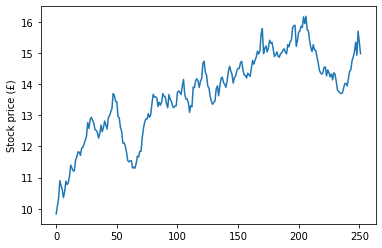

In [233]:
# forecasting with a random walk, assuming daily returns follow a normal distribution and are independent
# (No momentum here)
rand_vals_one_year = np.random.normal(mu, std, 252) + 1
initial_stock_price = 10
forecasted_values = initial_stock_price * rand_vals_one_year.cumprod()

plt.plot(forecasted_values)
plt.ylabel('Stock price (£)')
plt.show()

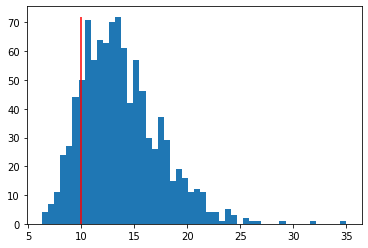

In [253]:
# Monte Carlo to get possible stock values a year from now
returns = []
for i in range(1000):
    rand_vals_one_year = np.random.normal(mu, std, 252) + 1
    forecasted_values = initial_stock_price * rand_vals_one_year.cumprod()
    returns.append(forecasted_values[-1])

plt.hist(returns, bins = 50)
vline_max = np.histogram(returns, bins = 50)[0].max()
plt.vlines(x = 10, ymin = 0, ymax = vline_max, colors = 'red')
plt.show()

In [254]:
# VaR over the next year could also be calculated using Monte Carlo

8.731917249233614